# ***Malwares Classification using VGG16 Architecture***

By Mohamed Shafeek T

### ***This research project also servers as the Implementation of transfer learning by using pre-trained Convolutional Neural Network (CNN) which is VGG16 architecture and fine-tuning the architecture to classify Malwares (Image-representation of malwares) belonging to 25 malware families.***

### **Requirements :**
#### **Dataset used :** 

**MalImg dataset (An open-source and one of the bench-mark malwares dataset where the malwares are already converted into images from malware binaries executable by Vision Research Lab organization).** 

#### **CNN model (A Deep Neural Network for image-related task) used :** 

**VGG16 (An architecture built by Visual Geometry Group, Department of Engineering Science, University of Oxford which was participated in ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) 2014 and showed amazing performance in the classification of images beloning to 1000 classes/categories).**

#### **GPU/Accelerator used :** 

**GPU T4 x2**

In [1]:
import os, math, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# ==== VISUALIZE INDIVIDUAL CHANNELS (Gray, Entropy, Sobel) ====
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

2025-09-06 19:44:50.923567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757187891.116514      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757187891.171623      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data = os.path.join("/kaggle/input/malimg-original/malimg_paper_dataset_imgs")

In [4]:
folders = [
    "Adialer.C",
    "Agent.FYI",
    "Allaple.A",
    "Allaple.L",
    "Alueron.gen!J",
    "Autorun.K",
    "C2LOP.P",
    "C2LOP.gen!g",
    "Dialplatform.B",
    "Dontovo.A",
    "Fakerean",
    "Instantaccess",
    "Lolyda.AA1",
    "Lolyda.AA2",
    "Lolyda.AA3",
    "Lolyda.AT",
    "Malex.gen!J",
    "Obfuscator.AD",
    "Rbot!gen",
    "Skintrim.N",
    "Swizzor.gen!E",
    "Swizzor.gen!I",
    "VB.AT",
    "Wintrim.BX",
    "Yuner.A"
]

In [5]:
# ====== CONFIG (matches your screenshot) ======
BASE_DIR = "/kaggle/input/malimg-original/malimg_paper_dataset_imgs"  # <— this exists
IMG_SIZE = 32
NUM_CHANNELS = 3
BATCH = 32
VAL_SPLIT = 0.10         # 10% validation
RANDOM_STATE = 42
AUTOTUNE = tf.data.AUTOTUNE

# ----- discover classes -----
assert os.path.isdir(BASE_DIR), f"Folder not found: {BASE_DIR}"
class_names = sorted([d for d in os.listdir(BASE_DIR)
                      if os.path.isdir(os.path.join(BASE_DIR, d))])
assert len(class_names) >= 20, f"Expected many family folders; found {len(class_names)}"
cls2idx = {c:i for i,c in enumerate(class_names)}
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} families:", class_names[:8], "...")

# ----- list files & labels -----
def _list_all(d):
    files, labels = [], []
    for c in class_names:
        cd = os.path.join(d, c)
        for fn in os.listdir(cd):
            if fn.lower().endswith((".png",".jpg",".jpeg",".bmp")):
                files.append(os.path.join(cd, fn))
                labels.append(cls2idx[c])
    return np.array(files), np.array(labels, np.int32)

all_files, all_labels = _list_all(BASE_DIR)
print(f"Total images: {len(all_files)}")

# ----- stratified train/val split -----
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT, random_state=RANDOM_STATE)
train_idx, val_idx = next(sss.split(all_files, all_labels))
train_files, train_labels = all_files[train_idx], all_labels[train_idx]
val_files,   val_labels   = all_files[val_idx],   all_labels[val_idx]
print(f"Train: {len(train_files)}  |  Val: {len(val_files)}")

# ----- channel constructors -----
def _sobel_mag_tf(img01):  # img01: (H,W,1) float32 [0,1]
    e  = tf.image.sobel_edges(img01[None])[0]   # (H,W,1,2)
    gx = e[...,0,0]; gy = e[...,0,1]
    return tf.sqrt(gx*gx + gy*gy)[...,None]     # (H,W,1)

def _local_entropy_np(gray01, win=5):
    import numpy as _np
    H,W,_ = gray01.shape
    pad = win//2
    g = _np.pad((gray01[:,:,0]*255).astype(_np.uint8),
                ((pad,pad),(pad,pad)), mode="edge")
    out = _np.zeros((H,W), _np.float32)
    for i in range(H):
        for j in range(W):
            patch = g[i:i+win, j:j+win]
            hist  = _np.bincount(patch.ravel(), minlength=256).astype(_np.float32)
            p = hist/(win*win); nz = p[p>0]
            out[i,j] = -(nz*_np.log2(nz)).sum()
    out = (out - out.min())/(out.ptp()+1e-6)
    return out[...,None].astype(_np.float32)

def _build_three_channels(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="area")
    img = tf.cast(img, tf.float32) / 255.0

    sob = _sobel_mag_tf(img)
    ent = tf.numpy_function(_local_entropy_np, [img], tf.float32)
    ent.set_shape([IMG_SIZE, IMG_SIZE, 1])

    x = tf.concat([img, ent, sob], axis=-1)  # (H,W,3)
    mean = tf.reduce_mean(x, axis=[0,1], keepdims=True)
    std  = tf.math.reduce_std(x, axis=[0,1], keepdims=True) + 1e-6
    x = (x - mean) / std
    y = tf.one_hot(label, NUM_CLASSES)
    return x, y

# ----- tf.data pipelines (no augmentation yet) -----
train_ds = (tf.data.Dataset.from_tensor_slices((train_files, train_labels))
            .shuffle(len(train_files), reshuffle_each_iteration=True)
            .map(lambda p,y: _build_three_channels(p,y), num_parallel_calls=AUTOTUNE)
            .batch(BATCH).prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((val_files, val_labels))
          .map(lambda p,y: _build_three_channels(p,y), num_parallel_calls=AUTOTUNE)
          .batch(BATCH).prefetch(AUTOTUNE))

steps_per_epoch = int(np.ceil(len(train_files) / BATCH))
print(f"steps_per_epoch={steps_per_epoch}")


Found 25 families: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g'] ...
Total images: 9339
Train: 8405  |  Val: 934


I0000 00:00:1757187906.333763      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


steps_per_epoch=263


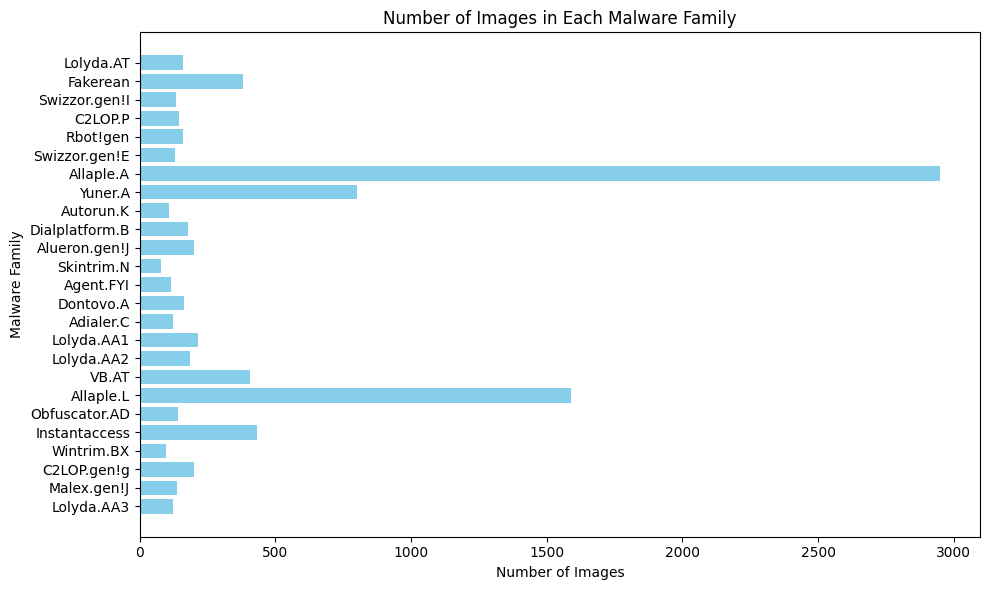

In [6]:
import os
import matplotlib.pyplot as plt

# Directory containing the malware families
malware_dir = '/kaggle/input/malimg-original/malimg_paper_dataset_imgs'

# Function to count images in each folder
def count_images(directory):
    counts = {}
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            counts[folder_name] = len(os.listdir(folder_path))
    return counts

# Counting images in each folder
malware_counts = count_images(malware_dir)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(list(malware_counts.keys()), list(malware_counts.values()), color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Malware Family')
plt.title('Number of Images in Each Malware Family')
plt.tight_layout()
plt.show()

In [7]:
# Function to count images in each folder
def count_images(directory):
    counts = {}
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            counts[folder_name] = len(os.listdir(folder_path))
    return counts

# Counting images in each folder
malware_counts = count_images(malware_dir)

# Printing the counts
for malware_family, count in malware_counts.items():
    print(f"{malware_family}: {count}")

Lolyda.AA3: 123
Malex.gen!J: 136
C2LOP.gen!g: 200
Wintrim.BX: 97
Instantaccess: 431
Obfuscator.AD: 142
Allaple.L: 1591
VB.AT: 408
Lolyda.AA2: 184
Lolyda.AA1: 213
Adialer.C: 122
Dontovo.A: 162
Agent.FYI: 116
Skintrim.N: 80
Alueron.gen!J: 198
Dialplatform.B: 177
Autorun.K: 106
Yuner.A: 800
Allaple.A: 2949
Swizzor.gen!E: 128
Rbot!gen: 158
C2LOP.P: 146
Swizzor.gen!I: 132
Fakerean: 381
Lolyda.AT: 159


In [8]:
# ----- Beta sampler (no tfp) -----
def _beta_sample(alpha, shape):
    g1 = tf.random.gamma(shape, alpha, dtype=tf.float32)
    g2 = tf.random.gamma(shape, alpha, dtype=tf.float32)
    lam = g1 / (g1 + g2)
    return tf.maximum(lam, 1.0 - lam)


# ----- MixUp + CutMix (fixed broadcasting) -----
def mixup_cutmix(ds, alpha_mixup=0.4, alpha_cutmix=1.0, p_cutmix=0.5):
    def _map(x, y):
        b = tf.shape(x)[0]
        idx = tf.random.shuffle(tf.range(b))
        x2, y2 = tf.gather(x, idx), tf.gather(y, idx)

        lam = _beta_sample(alpha_mixup, [b, 1, 1, 1])
        lam_y = tf.reshape(lam[:, 0, 0, 0], [b, 1])

        def _mixup():
            xm = lam * x + (1.0 - lam) * x2
            ym = lam_y * y + (1.0 - lam_y) * y2
            return xm, ym

        def _cutmix():
            H = tf.shape(x)[1]; W = tf.shape(x)[2]
            r  = tf.reshape(_beta_sample(alpha_cutmix, [b, 1]), [b])  # (0,1)
            rw = tf.cast(tf.sqrt(1.0 - r) * tf.cast(W, tf.float32), tf.int32)
            rh = tf.cast(tf.sqrt(1.0 - r) * tf.cast(H, tf.float32), tf.int32)
            rx = tf.random.uniform([b], 0, W, dtype=tf.int32)
            ry = tf.random.uniform([b], 0, H, dtype=tf.int32)
            x1 = tf.clip_by_value(rx - rw // 2, 0, W)
            y1 = tf.clip_by_value(ry - rh // 2, 0, H)
            x2p = tf.clip_by_value(x1 + rw, 0, W)
            y2p = tf.clip_by_value(y1 + rh, 0, H)

            # reshape bounds -> [B,1,1,1] so they broadcast with grids
            x1e = tf.reshape(x1,  [b, 1, 1, 1]); x2e = tf.reshape(x2p, [b, 1, 1, 1])
            y1e = tf.reshape(y1,  [b, 1, 1, 1]); y2e = tf.reshape(y2p, [b, 1, 1, 1])

            grid_x = tf.reshape(tf.range(W, dtype=tf.int32), [1, 1, W, 1])
            grid_y = tf.reshape(tf.range(H, dtype=tf.int32), [1, H, 1, 1])

            mask_x = tf.cast((grid_x >= x1e) & (grid_x < x2e), tf.float32)  # [B,1,W,1]
            mask_y = tf.cast((grid_y >= y1e) & (grid_y < y2e), tf.float32)  # [B,H,1,1]
            box = mask_y * mask_x                                           # [B,H,W,1]

            xm = x * (1.0 - box) + x2 * box
            area = tf.reduce_mean(box, axis=[1, 2, 3])                      # [B]
            ym = (1.0 - area)[:, None] * y + area[:, None] * y2
            return xm, ym

        return tf.cond(tf.random.uniform([]) < p_cutmix, _cutmix, _mixup)

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)


# ----- Random erase + mild crop jitter -----
def _random_erase(x, y, p=0.25):
    if tf.random.uniform([]) < p:
        H = tf.shape(x)[1]; W = tf.shape(x)[2]
        side = tf.random.uniform([], int(0.05 * tf.cast(H, tf.float32)),
                                     int(0.12 * tf.cast(H, tf.float32)), dtype=tf.int32)
        i = tf.random.uniform([], 0, H - side, dtype=tf.int32)
        j = tf.random.uniform([], 0, W - side, dtype=tf.int32)
        mask = tf.ones([1, side, side, 1], x.dtype)
        pad  = tf.image.pad_to_bounding_box(mask, i, j, H, W)
        x = x * (1.0 - pad)
    return x, y

def _mild_crop_jitter(x, y):
    x = tf.image.pad_to_bounding_box(x, 1, 1, IMG_SIZE + 2, IMG_SIZE + 2)
    x = tf.image.random_crop(x, size=[tf.shape(x)[0], IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    return x, y


# ----- Build augmented training dataset -----
train_ds_aug = (train_ds
                .map(_mild_crop_jitter, num_parallel_calls=AUTOTUNE)
                .map(_random_erase,     num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))
train_ds_aug = mixup_cutmix(train_ds_aug, alpha_mixup=0.4, alpha_cutmix=1.0, p_cutmix=0.5)

# sanity check
xb, yb = next(iter(train_ds.take(1)))
print("batch:", xb.shape, yb.shape)  # -> (B, IMG_SIZE, IMG_SIZE, 3), (B, NUM_CLASSES)

print("OK: using single-folder dataset → stratified split + 3-channel preprocessing + MixUp/CutMix/Erase")


batch: (32, 32, 32, 3) (32, 25)
OK: using single-folder dataset → stratified split + 3-channel preprocessing + MixUp/CutMix/Erase


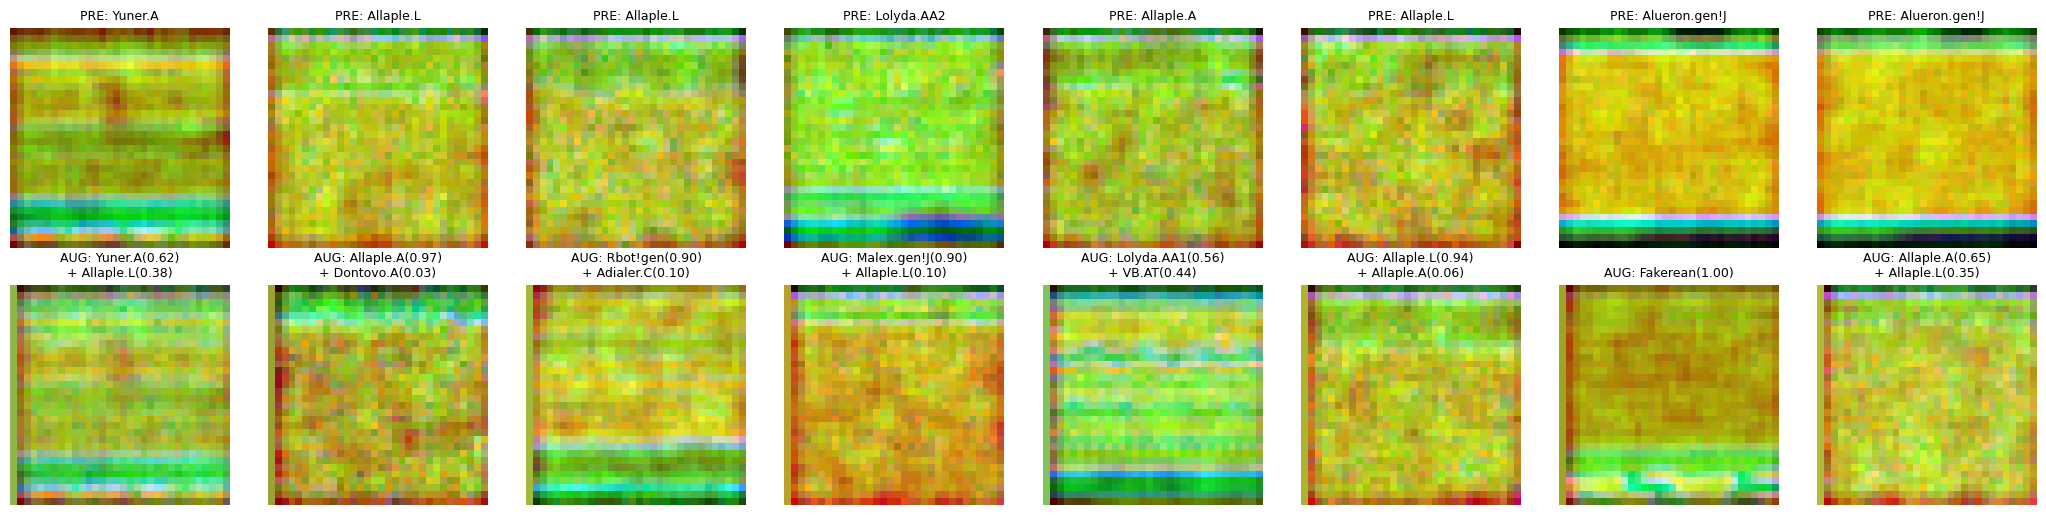

In [9]:
# ==== VISUALIZE PREPROCESSED vs AUGMENTED SAMPLES ====
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

def _to_display_rgb(x):
    """Per-image, per-channel min-max to [0,1] for nice viewing."""
    x = x.numpy() if isinstance(x, tf.Tensor) else x
    mn = x.min(axis=(0,1), keepdims=True)
    mx = x.max(axis=(0,1), keepdims=True)
    out = (x - mn) / (mx - mn + 1e-6)
    return np.clip(out, 0, 1)

# grab one batch from each pipeline
xb_pre, yb_pre = next(iter(train_ds.take(1)))
xb_aug, yb_aug = next(iter(train_ds_aug.take(1)))

n = int(min(8, xb_pre.shape[0], xb_aug.shape[0]))  # show up to 8
fig, axes = plt.subplots(2, n, figsize=(2.6*n, 5.2))
if n == 1:
    axes = np.array([[axes[0]], [axes[1]]])  # ensure 2×n indexing works

for i in range(n):
    # --- preprocessed (no aug) ---
    im_pre = _to_display_rgb(xb_pre[i])
    true_idx = int(np.argmax(yb_pre[i].numpy()))
    axes[0, i].imshow(im_pre)
    axes[0, i].set_title(f"PRE: {class_names[true_idx]}", fontsize=9)
    axes[0, i].axis("off")

    # --- augmented (MixUp/CutMix labels are soft) ---
    im_aug = _to_display_rgb(xb_aug[i])
    y = yb_aug[i].numpy()
    top2 = np.argsort(-y)[:2]
    lbl = f"{class_names[top2[0]]}({y[top2[0]]:.2f})"
    if y[top2[1]] > 1e-6:
        lbl += f"\n+ {class_names[top2[1]]}({y[top2[1]]:.2f})"
    axes[1, i].imshow(im_aug)
    axes[1, i].set_title(f"AUG: {lbl}", fontsize=9)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


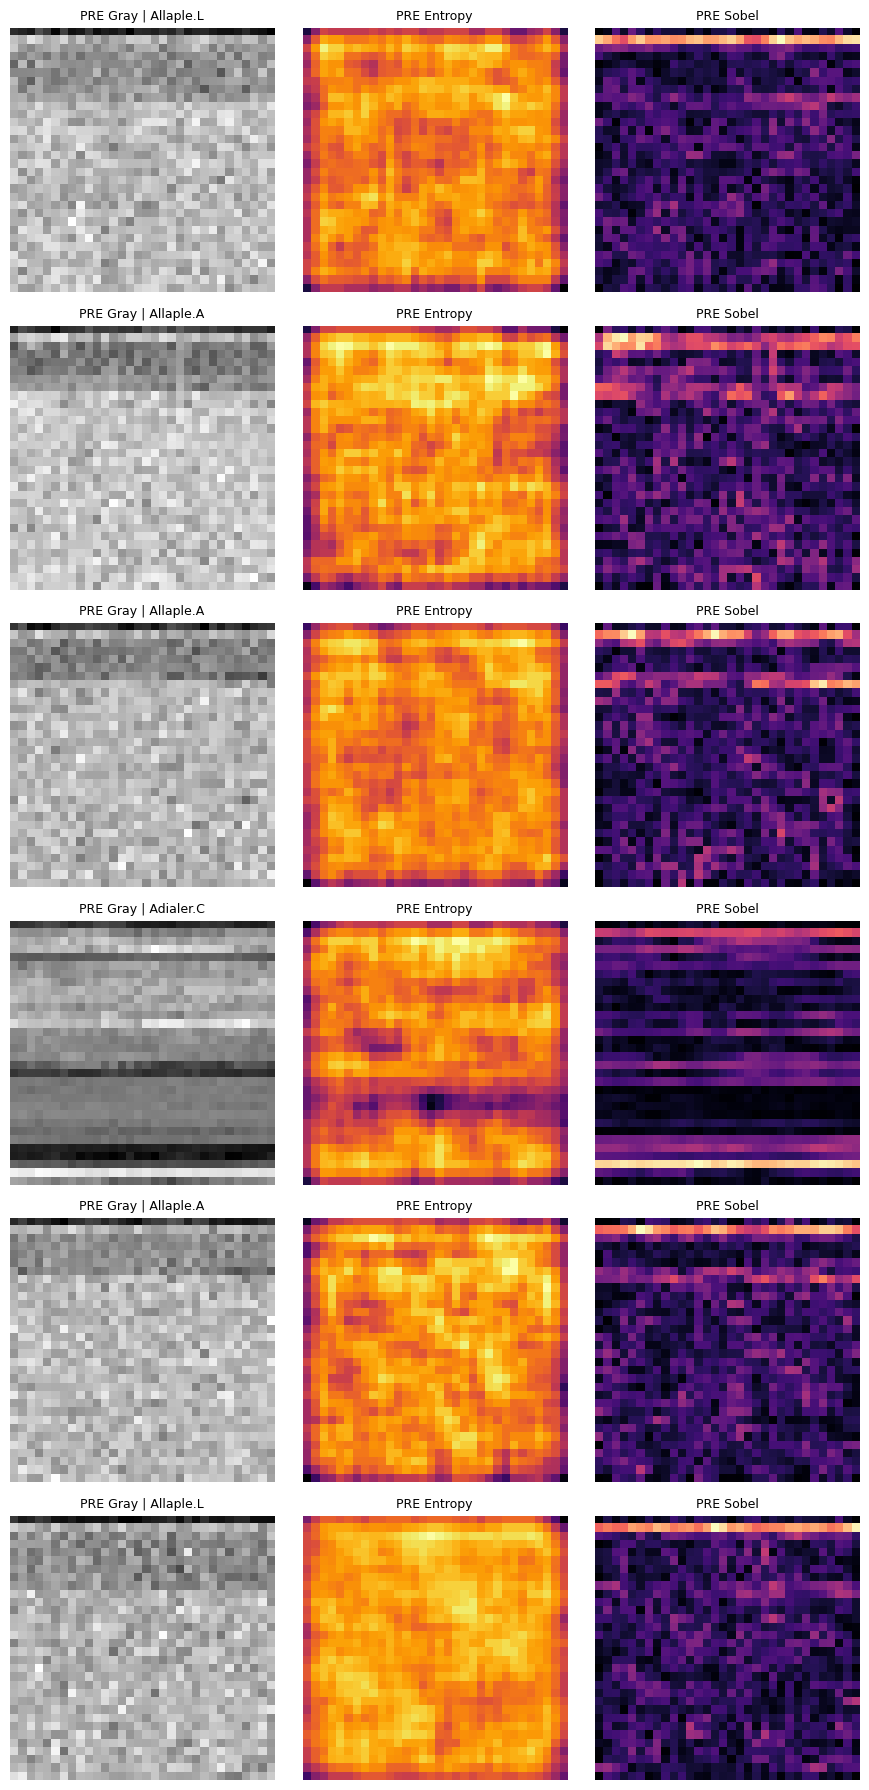

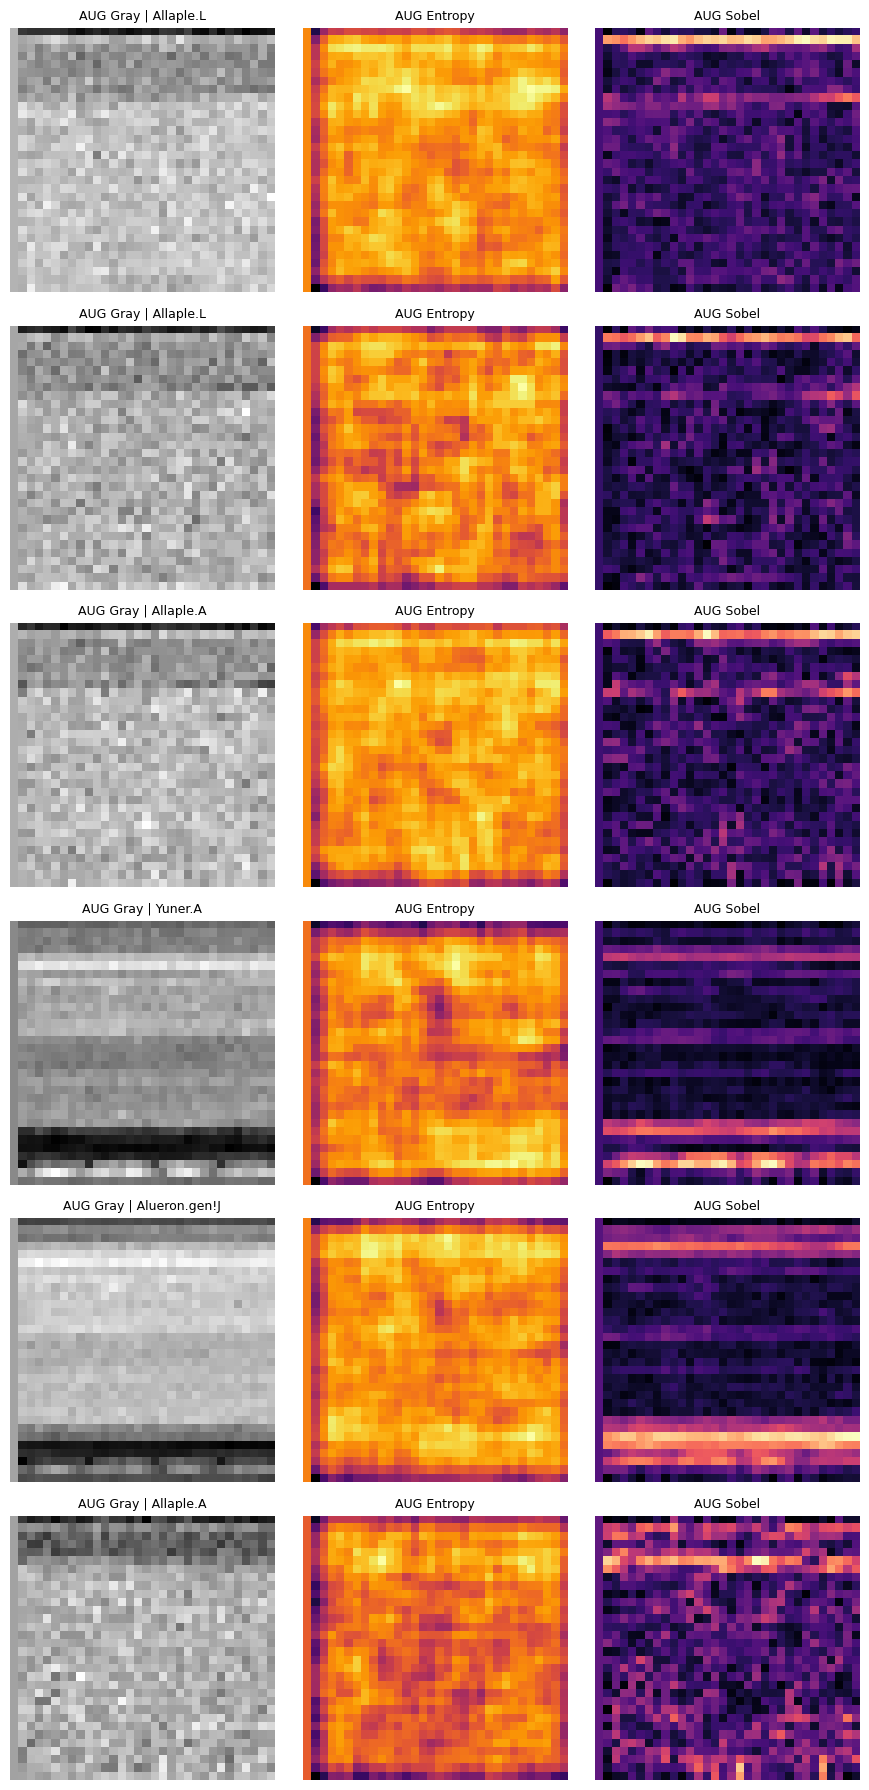

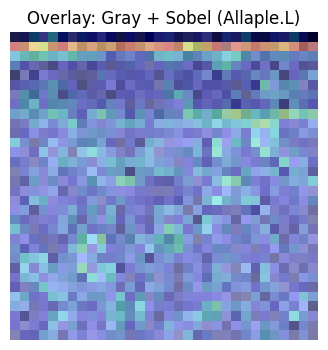

In [10]:
# ==== VISUALIZE INDIVIDUAL CHANNELS (Gray, Entropy, Sobel) ====
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

def _mm01(a):
    a = a.astype(np.float32)
    a = a - a.min()
    a = a / (a.max() + 1e-6)
    return np.clip(a, 0, 1)

def show_channels(batch_x, batch_y, title_prefix="PRE", max_rows=6):
    """batch_x: (B,H,W,3) with channels [gray, entropy, sobel] (standardized)."""
    B, H, W, C = batch_x.shape
    n = min(max_rows, B)
    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    if n == 1:
        axes = np.array([axes])  # ensure 2D indexing
    for i in range(n):
        x = batch_x[i].numpy() if tf.is_tensor(batch_x) else batch_x[i]
        y = batch_y[i].numpy() if tf.is_tensor(batch_y) else batch_y[i]
        g, e, s = x[...,0], x[...,1], x[...,2]   # gray, entropy, sobel (standardized)
        # per-channel min-max for display
        g, e, s = _mm01(g), _mm01(e), _mm01(s)
        true_idx = int(np.argmax(y))
        axes[i,0].imshow(g, cmap="gray");    axes[i,0].set_title(f"{title_prefix} Gray | {class_names[true_idx]}", fontsize=9)
        axes[i,1].imshow(e, cmap="inferno"); axes[i,1].set_title(f"{title_prefix} Entropy", fontsize=9)
        axes[i,2].imshow(s, cmap="magma");   axes[i,2].set_title(f"{title_prefix} Sobel", fontsize=9)
        for j in range(3):
            axes[i,j].axis("off")
    plt.tight_layout(); plt.show()

# grab a batch from preprocessed (no aug) and augmented
xb_pre, yb_pre = next(iter(train_ds.take(1)))
show_channels(xb_pre, yb_pre, title_prefix="PRE", max_rows=6)

xb_aug, yb_aug = next(iter(train_ds_aug.take(1)))
show_channels(xb_aug, yb_aug, title_prefix="AUG", max_rows=6)

# (Optional) overlay Sobel edges on gray for the first preprocessed sample
g = xb_pre[0][...,0].numpy(); s = xb_pre[0][...,2].numpy()
g_v = _mm01(g); s_v = _mm01(s)
plt.figure(figsize=(4.5,4))
plt.imshow(g_v, cmap="gray")
plt.imshow(s_v, cmap="jet", alpha=0.35)  # colored edges overlay
plt.title(f"Overlay: Gray + Sobel ({class_names[int(np.argmax(yb_pre[0].numpy()))]})")
plt.axis("off"); plt.show()


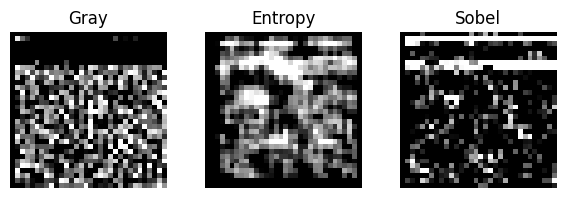

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# get one (x,y) from train_ds_aug or raw ds (x shape: H,W,3 in [0,1])
x, y = next(iter(train_ds_aug.unbatch().batch(1)))
img = x[0].numpy()  # 32x32x3

titles = ["Gray", "Entropy", "Sobel"]
plt.figure(figsize=(6,2))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow(img[..., i], cmap='gray', vmin=0, vmax=1)
    ax.set_title(titles[i]); ax.axis('off')
plt.tight_layout(); plt.show()


In [12]:
# ====== LOSS: Class-Balanced Focal (with Deferred Re-Weighting) ======
unique, counts = np.unique(train_labels, return_counts=True)
class_counts = np.zeros(NUM_CLASSES, dtype=np.int32)
class_counts[unique] = counts

class CBFocalLoss(keras.losses.Loss):
    def __init__(self, class_counts, beta=0.9999, gamma=1.5, name="cb_focal"):
        super().__init__(reduction=keras.losses.Reduction.NONE, name=name)
        self.gamma = float(gamma)
        self.beta = float(beta)
        eff_num = 1.0 - np.power(self.beta, class_counts)
        w = (1.0 - self.beta) / np.maximum(eff_num, 1e-8)
        self.class_weights = (w / w.sum()) * len(class_counts)  # normalize
        self.enable_drw = False

    def set_drw(self, flag: bool):
        self.enable_drw = bool(flag)

    def call(self, y_true, y_pred):
        # y_true: one-hot, y_pred: probabilities
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)             # [B]
        focal = tf.pow(1.0 - pt, self.gamma)                     # [B]
        if self.enable_drw:
            alpha = tf.reduce_sum(
                y_true * tf.constant(self.class_weights, dtype=tf.float32), axis=-1
            )                                                    # [B]
        else:
            alpha = 1.0
        return alpha * focal * (-tf.math.log(pt))

cb_focal = CBFocalLoss(class_counts, beta=0.9999, gamma=1.5)
def teacher_loss(y_true, logits):
    return cb_focal(y_true, tf.nn.softmax(logits))

# teacher.compile(optimizer=opt, loss=teacher_loss, metrics=['accuracy'])


In [13]:
# ====== LR SCHEDULE + OPTIMIZER ======
steps_per_epoch = int(np.ceil(len(train_files) / BATCH))
total_epochs    = 50
warmup_epochs   = 5

class WarmCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, steps_per_epoch, total_epochs, warmup_epochs):
        self.base_lr = float(base_lr)
        self.spe = int(steps_per_epoch)
        self.T = int(total_epochs * steps_per_epoch)
        self.W = int(warmup_epochs * steps_per_epoch)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        def _warm():
            return self.base_lr * (step / tf.maximum(1.0, tf.cast(self.W, tf.float32)))
        def _cos():
            return 0.5 * self.base_lr * (
                1.0 + tf.cos(np.pi * (step - self.W) / tf.maximum(1.0, self.T - self.W))
            )
        return tf.where(step < self.W, _warm(), _cos())

lr_schedule = WarmCosine(base_lr=3e-4,
                         steps_per_epoch=steps_per_epoch,
                         total_epochs=total_epochs,
                         warmup_epochs=warmup_epochs)

try:
    opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
except Exception:
    # Fallback if AdamW is unavailable
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)


In [14]:
# ====== LR SCHEDULE + OPTIMIZER ======
steps_per_epoch = int(np.ceil(len(train_files) / BATCH))
total_epochs    = 50
warmup_epochs   = 5

class WarmCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, steps_per_epoch, total_epochs, warmup_epochs):
        self.base_lr = float(base_lr)
        self.spe = int(steps_per_epoch)
        self.T = int(total_epochs * steps_per_epoch)
        self.W = int(warmup_epochs * steps_per_epoch)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        def _warm():
            return self.base_lr * (step / tf.maximum(1.0, tf.cast(self.W, tf.float32)))
        def _cos():
            return 0.5 * self.base_lr * (
                1.0 + tf.cos(np.pi * (step - self.W) / tf.maximum(1.0, self.T - self.W))
            )
        return tf.where(step < self.W, _warm(), _cos())

lr_schedule = WarmCosine(base_lr=3e-4,
                         steps_per_epoch=steps_per_epoch,
                         total_epochs=total_epochs,
                         warmup_epochs=warmup_epochs)

try:
    opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
except Exception:
    # Fallback if AdamW is unavailable
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)


In [15]:
# ====== DRW (Deferred Re-Weighting) toggle ======
class DRWCallback(keras.callbacks.Callback):
    def __init__(self, loss_obj, start_epoch=10):
        super().__init__()
        self.loss_obj = loss_obj
        self.start_epoch = int(start_epoch)

    def on_epoch_begin(self, epoch, logs=None):
        use_weights = (epoch + 1) >= (self.start_epoch + 1)
        self.loss_obj.set_drw(use_weights)
        if epoch == self.start_epoch:
            print(">> DRW enabled (class-balanced weights now active).")


In [16]:
# ====== METRIC: Macro-F1 callback (no TensorFlow Addons needed) ======
from sklearn.metrics import f1_score

class MacroF1Callback(keras.callbacks.Callback):
    """Computes macro-F1 on val_ds each epoch; logs as 'val_macro_f1'."""
    def __init__(self, val_ds):
        super().__init__()
        ys = []
        for _, y in val_ds.unbatch().batch(4096):
            ys.append(y.numpy())
        self.y_true = np.argmax(np.concatenate(ys, axis=0), axis=1)
        self.val_ds = val_ds

    def on_epoch_end(self, epoch, logs=None):
        preds = []
        for x, _ in self.val_ds:
            p = self.model.predict(x, verbose=0)
            preds.append(np.argmax(p, axis=1))
        y_pred = np.concatenate(preds, axis=0)
        f1 = f1_score(self.y_true, y_pred, average='macro')
        if logs is not None:
            logs['val_macro_f1'] = f1
        print(f"\nval_macro_f1: {f1:.4f}")

macro_f1_cb = MacroF1Callback(val_ds)


In [17]:
# # # COMPILE (unchanged)
# # teacher.compile(optimizer=opt, loss=cb_focal, metrics=['accuracy'])
# # def teacher_loss(y_true, logits):
# #     return cb_focal(y_true, tf.nn.softmax(logits))

# teacher.compile(optimizer=opt, loss=teacher_loss, metrics=['accuracy'])

# # CALLBACKS (with fixed checkpoint path)
# ckpt = keras.callbacks.ModelCheckpoint(
#     "best_conv_attn.weights.h5",
#     monitor="val_macro_f1", mode="max",
#     save_best_only=True, save_weights_only=True
# )
# early = keras.callbacks.EarlyStopping(
#     monitor="val_macro_f1", mode="max",
#     patience=8, restore_best_weights=True
# )

# # Train (keep MacroF1Callback BEFORE ckpt so the metric is in logs)
# history = teacher.fit(
#     train_ds_aug,
#     validation_data=val_ds,
#     epochs=2,
#     callbacks=[DRWCallback(cb_focal, start_epoch=10), macro_f1_cb, ckpt, early],
#     verbose=1
# )


In [18]:
# # ====== METRIC: Macro-F1 callback (no TensorFlow Addons needed) ======
# from sklearn.metrics import f1_score

# class MacroF1Callback(keras.callbacks.Callback):
#     """Computes macro-F1 on val_ds each epoch; logs as 'val_macro_f1'."""
#     def __init__(self, val_ds):
#         super().__init__()
#         ys = []
#         for _, y in val_ds.unbatch().batch(4096):
#             ys.append(y.numpy())
#         self.y_true = np.argmax(np.concatenate(ys, axis=0), axis=1)
#         self.val_ds = val_ds

#     def on_epoch_end(self, epoch, logs=None):
#         preds = []
#         for x, _ in self.val_ds:
#             p = self.model.predict(x, verbose=0)
#             preds.append(np.argmax(p, axis=1))
#         y_pred = np.concatenate(preds, axis=0)
#         f1 = f1_score(self.y_true, y_pred, average='macro')
#         if logs is not None:
#             logs['val_macro_f1'] = f1
#         print(f"\nval_macro_f1: {f1:.4f}")

# macro_f1_cb = MacroF1Callback(val_ds)


In [19]:
# # ====== EVALUATION: metrics + confusion matrices ======
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     accuracy_score, f1_score, classification_report,
#     confusion_matrix, precision_recall_fscore_support, roc_auc_score
# )
# import pandas as pd
# model = teacher
# # 1) Collect predictions and targets
# y_true_onehot = []
# y_prob = []
# for xb, yb in val_ds:
#     pb = model.predict(xb, verbose=0)
#     y_prob.append(pb)
#     y_true_onehot.append(yb.numpy())

# y_prob = np.concatenate(y_prob, axis=0)                   # [N, C]
# y_true_onehot = np.concatenate(y_true_onehot, axis=0)     # [N, C]
# y_true = y_true_onehot.argmax(1)                          # [N]
# y_pred = y_prob.argmax(1)                                 # [N]

# # 2) Core metrics
# acc        = accuracy_score(y_true, y_pred)
# f1_macro   = f1_score(y_true, y_pred, average='macro')
# f1_weight  = f1_score(y_true, y_pred, average='weighted')
# f1_micro   = f1_score(y_true, y_pred, average='micro')

# # Top-k utility
# def topk_acc(probs, y_true_idx, k=5):
#     # True if the true class is in the top-k predicted
#     topk = np.argpartition(probs, -k, axis=1)[:, -k:]
#     hits = (topk == y_true_idx[:, None]).any(axis=1)
#     return hits.mean()

# top5 = topk_acc(y_prob, y_true, k=5)

# print(f"Accuracy        : {acc:.4f}")
# print(f"F1 (macro)      : {f1_macro:.4f}")
# print(f"F1 (weighted)   : {f1_weight:.4f}")
# print(f"F1 (micro)      : {f1_micro:.4f}")
# print(f"Top-5 Accuracy  : {top5:.4f}")

# # Optional: macro AUC (OVR) needs probabilities + one-hot
# try:
#     auc_macro = roc_auc_score(y_true_onehot, y_prob, multi_class='ovr', average='macro')
#     print(f"ROC AUC (macro, OVR): {auc_macro:.4f}")
# except Exception as e:
#     print("ROC AUC not computed:", e)

# # 3) Classification report (per-class)
# report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
# print("\n=== Classification report ===\n", report)

# # 4) Confusion matrices
# cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
# cm_norm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# axes[0].imshow(cm, interpolation='nearest')
# axes[0].set_title('Confusion Matrix (counts)')
# axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
# axes[0].set_xticks(range(NUM_CLASSES)); axes[0].set_yticks(range(NUM_CLASSES))
# axes[0].set_xticklabels([c[:8] for c in class_names], rotation=90, fontsize=7)
# axes[0].set_yticklabels([c[:12] for c in class_names], fontsize=7)
# fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

# im = axes[1].imshow(cm_norm, vmin=0.0, vmax=1.0, interpolation='nearest')
# axes[1].set_title('Confusion Matrix (row-normalized)')
# axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
# axes[1].set_xticks(range(NUM_CLASSES)); axes[1].set_yticks(range(NUM_CLASSES))
# axes[1].set_xticklabels([c[:8] for c in class_names], rotation=90, fontsize=7)
# axes[1].set_yticklabels([c[:12] for c in class_names], fontsize=7)
# fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
# plt.tight_layout()
# plt.show()

# # 5) Per-class table (precision/recall/F1/support)
# prec, rec, f1, sup = precision_recall_fscore_support(
#     y_true, y_pred, labels=range(NUM_CLASSES), zero_division=0
# )
# per_class_df = pd.DataFrame({
#     "class": class_names,
#     "support": sup,
#     "precision": np.round(prec, 4),
#     "recall": np.round(rec, 4),
#     "f1": np.round(f1, 4),
# }).sort_values("f1", ascending=True).reset_index(drop=True)

# print("\n=== Worst classes by F1 ===")
# display(per_class_df.head(10))
# print("\n=== Best classes by F1 ===")
# display(per_class_df.tail(10))


In [20]:
# # ==== ONE EXAMPLE PER CLASS: actual vs predicted (validation set) ====
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import math

# # 1) Get predictions on val_ds (if not already computed)
# y_probs = []
# y_true_oh = []
# for xb, yb in val_ds:
#     y_probs.append(model.predict(xb, verbose=0))
#     y_true_oh.append(yb.numpy())
# y_probs = np.concatenate(y_probs, axis=0)           # [N, C]
# y_true_oh = np.concatenate(y_true_oh, axis=0)       # [N, C]
# y_true = y_true_oh.argmax(1)                        # [N]
# y_pred = y_probs.argmax(1)                          # [N]
# y_conf = y_probs.max(1)                             # [N]
# N = len(y_true)

# # 2) Pick one representative sample per class (highest model confidence)
# example_indices = []
# for ci in range(NUM_CLASSES):
#     idxs = np.where(y_true == ci)[0]
#     if len(idxs) == 0:
#         continue
#     # choose the sample (of this true class) with max predicted confidence
#     best = idxs[np.argmax(y_conf[idxs])]
#     example_indices.append(best)

# # 3) Plot grid
# cols = 5
# rows = math.ceil(len(example_indices) / cols)
# plt.figure(figsize=(3.4*cols, 3.4*rows))

# for k, i in enumerate(example_indices):
#     # read original grayscale for display
#     p = val_files[i]
#     raw = tf.io.read_file(p)
#     img = tf.io.decode_image(raw, channels=1, expand_animations=False).numpy().squeeze()

#     true_lbl = class_names[y_true[i]]
#     pred_lbl = class_names[y_pred[i]]
#     conf = y_probs[i, y_pred[i]]

#     ax = plt.subplot(rows, cols, k+1)
#     ax.imshow(img, cmap="gray")
#     ax.axis("off")
#     color = "tab:green" if y_true[i] == y_pred[i] else "tab:red"
#     ax.set_title(f"True: {true_lbl}\nPred: {pred_lbl} ({conf:.2f})", color=color, fontsize=9)

# plt.tight_layout()
# plt.show()


In [21]:
# import matplotlib.pyplot as plt

# hist = history.history
# print("history keys:", list(hist.keys()))

# # Safely get keys even if some are missing
# loss      = hist.get("loss", [])
# val_loss  = hist.get("val_loss", [])
# acc       = hist.get("accuracy", hist.get("acc", []))
# val_acc   = hist.get("val_accuracy", hist.get("val_acc", []))
# val_f1    = hist.get("val_macro_f1", [])

# epochs = range(1, max(len(loss), len(val_loss), len(acc), len(val_acc), len(val_f1)) + 1)

# plt.figure(figsize=(12,4))

# # Loss
# plt.subplot(1,3,1)
# if loss:     plt.plot(epochs, loss, label="train")
# if val_loss: plt.plot(epochs, val_loss, label="val")
# plt.title("Loss"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, ls="--", alpha=.4)

# # Accuracy
# plt.subplot(1,3,2)
# if acc:     plt.plot(epochs, acc, label="train")
# if val_acc: plt.plot(epochs, val_acc, label="val")
# plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, ls="--", alpha=.4)

# # Macro-F1 (from our callback)
# plt.subplot(1,3,3)
# if val_f1: plt.plot(epochs[:len(val_f1)], val_f1, label="val macro-F1")
# plt.title("Macro-F1 (val)"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, ls="--", alpha=.4)

# plt.tight_layout()
# plt.show()


# New Teacher

In [22]:
early = keras.callbacks.EarlyStopping(
    monitor="val_macro_f1", mode="max",
    patience=8, restore_best_weights=True
)

In [23]:
# ---- replace the old speedup(...) with this safe version ----
import tensorflow as tf

def speedup(ds, cache=False):
    if cache:
        ds = ds.cache()  # only if it fits in RAM; otherwise leave False
    opts = tf.data.Options()
    try:
        opts.experimental_deterministic = False
    except Exception:
        pass
    # Enable default graph optimizations
    try:
        opts.experimental_optimization.apply_default_optimizations = True
    except Exception:
        pass
    # Try enabling a few common flags if your TF exposes them
    for flag in ("map_parallelization", "parallel_batch", "map_fusion",
                 "filter_fusion", "map_and_batch_fusion"):
        try:
            setattr(opts.experimental_optimization, flag, True)
        except Exception:
            pass
    ds = ds.with_options(opts)
    return ds.prefetch(tf.data.AUTOTUNE)

# use it (cache val if small; leave train uncached if you do heavy aug)
train_ds_aug = speedup(train_ds_aug, cache=False)
val_ds       = speedup(val_ds, cache=True)


In [24]:
# ==========================================
# TEACHER = exactly your previous student net
# (ACB + TripletAttention + Fusion + GAB, logits-out)
# ==========================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW

# ---- constants ----
IMG_SIZE     = 32
NUM_CHANNELS = 3   # Gray | Entropy | Sobel
# NUM_CLASSES must already be defined in your notebook

# ---------- building blocks (same as before) ----------
class AsymmetricConvBlock(layers.Layer):
    """ACB: 3x3 + (1x3) + (3x1) -> BN -> GELU."""
    def __init__(self, out_ch, use_bias=False):
        super().__init__()
        self.conv33 = layers.Conv2D(out_ch, 3, padding="same", use_bias=use_bias)
        self.conv13 = layers.Conv2D(out_ch, (1,3), padding="same", use_bias=use_bias)
        self.conv31 = layers.Conv2D(out_ch, (3,1), padding="same", use_bias=use_bias)
        self.bn = layers.BatchNormalization()
        self.act = layers.Activation(tf.nn.gelu)
    def call(self, x, training=False):
        y = self.conv33(x) + self.conv13(x) + self.conv31(x)
        y = self.bn(y, training=training)
        return self.act(y)

class TripletAttention(layers.Layer):
    """Convolutional Triplet Attention (compact)."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = layers.Conv2D(1, kernel_size, padding="same", use_bias=False)
        self.bn   = layers.BatchNormalization()
    def _branch(self, x, training=False):
        xm = tf.reduce_max(x, axis=-1, keepdims=True)
        xa = tf.reduce_mean(x, axis=-1, keepdims=True)
        y  = tf.concat([xm, xa], axis=-1)
        y  = self.conv(y); y = self.bn(y, training=training)
        w  = tf.nn.sigmoid(y)
        return x * w
    def _perm(self, x, perm, inv, training=False):
        y = tf.transpose(x, perm)
        y = self._branch(y, training=training)
        return tf.transpose(y, inv)
    def call(self, x, training=False):
        b1 = self._branch(x, training=training)
        b2 = self._perm(x, (0,2,1,3), (0,2,1,3), training=training)
        b3 = self._perm(x, (0,3,2,1), (0,3,2,1), training=training)
        return (b1 + b2 + b3) / 3.0

class GlobalAttentionBlock(layers.Layer):
    """Light global attention (SE-like channel gate + spatial gate)."""
    def __init__(self, r=4):
        super().__init__()
        self.r = r
        self.pool = layers.GlobalAveragePooling2D()
        self.act  = layers.Activation(tf.nn.gelu)
        self.spatial = layers.Conv2D(1, 1, padding="same")
    def build(self, input_shape):
        c = int(input_shape[-1])
        self.fc1 = layers.Dense(max(c//self.r, 8), use_bias=False)
        self.fc2 = layers.Dense(c, use_bias=False)
    def call(self, x, training=False):
        z = self.pool(x)
        z = self.fc1(z); z = self.act(z)
        z = self.fc2(z); z = tf.nn.sigmoid(z)
        x = x * tf.reshape(z, [-1,1,1,tf.shape(x)[-1]])
        s = tf.nn.sigmoid(self.spatial(x))
        return x * s

def ResBlock_AsymTA(x, out_ch, stride=1):
    """Same bottleneck as your student: 1x1 -> ACB -> 1x1 + TripletAttention + residual."""
    skip = x
    if stride != 1 or x.shape[-1] != out_ch:
        skip = layers.Conv2D(out_ch, 1, strides=stride, use_bias=False, padding="same")(skip)
        skip = layers.BatchNormalization()(skip)
    y = layers.Conv2D(out_ch//4, 1, strides=stride, use_bias=False, padding="same")(x)
    y = layers.BatchNormalization()(y); y = layers.Activation(tf.nn.gelu)(y)
    y = AsymmetricConvBlock(out_ch//4)(y)
    y = layers.Conv2D(out_ch, 1, use_bias=False, padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = TripletAttention()(y)
    y = layers.Add()([skip, y])
    return layers.Activation(tf.nn.gelu)(y)

def VGGBlock_AsymTA(x, out_ch, blocks=2, pool=True):
    """Same improved VGG-style block as your student."""
    for _ in range(blocks):
        x = AsymmetricConvBlock(out_ch)(x)
        x = TripletAttention()(x)
    if pool:
        x = layers.MaxPooling2D(2)(x)
    return x

# ---------- EXACT SAME ARCH builder (renamed as teacher) ----------
def build_teacher_same_as_student(num_classes, in_ch=NUM_CHANNELS,
                                  res_widths=(64,128,160),
                                  vgg_widths=(64,128,128),
                                  fuse_ch=192):
    """
    Teacher with EXACTLY the same architecture as the earlier student.
    32x32 input -> Res branch + VGG branch -> concat -> 1x1 fuse -> GAB -> GAP -> logits
    """
    inp = layers.Input((None, None, in_ch))
    x   = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)

    # Res branch
    r = layers.Conv2D(32, 3, padding="same", use_bias=False)(x); r = layers.BatchNormalization()(r); r = layers.Activation(tf.nn.gelu)(r)
    r = ResBlock_AsymTA(r, res_widths[0], stride=1)  # 32x32
    r = ResBlock_AsymTA(r, res_widths[1], stride=2)  # 32->16
    r = ResBlock_AsymTA(r, res_widths[1], stride=1)  # 16x16
    r = ResBlock_AsymTA(r, res_widths[2], stride=2)  # 16->8
    r = ResBlock_AsymTA(r, res_widths[2], stride=1)  # 8x8

    # VGG branch
    v = layers.Conv2D(32, 3, padding="same", use_bias=False)(x); v = layers.BatchNormalization()(v); v = layers.Activation(tf.nn.gelu)(v)
    v = VGGBlock_AsymTA(v, vgg_widths[0], blocks=2, pool=True)  # 32->16
    v = VGGBlock_AsymTA(v, vgg_widths[1], blocks=2, pool=True)  # 16->8
    v = VGGBlock_AsymTA(v, vgg_widths[2], blocks=1, pool=False) # 8x8

    # Fuse + head
    f = layers.Concatenate()([r, v])                 # 8x8 concat
    f = layers.Conv2D(fuse_ch, 1, use_bias=False, padding="same")(f)
    f = layers.BatchNormalization()(f); f = layers.Activation(tf.nn.gelu)(f)
    f = GlobalAttentionBlock(r=4)(f)
    f = layers.GlobalAveragePooling2D()(f)
    logits = layers.Dense(num_classes, activation=None, name="logits")(f)  # logits (no softmax)
    model = keras.Model(inp, logits, name="Teacher_MCKDFF_32_Same")
    return model

# ---------- build ----------
teacher = build_teacher_same_as_student(NUM_CLASSES, in_ch=NUM_CHANNELS)
#teacher.summary()

# ---------- loss wrapper (focal expects probs; model outputs logits) ----------
def teacher_loss(y_true, logits):
    return cb_focal(y_true, tf.nn.softmax(logits))

# ---------- fresh optimizer ----------
teacher_opt = AdamW(learning_rate=3e-4, weight_decay=1e-4)
# turn OFF eager and use JIT + larger steps_per_execution
tf.config.run_functions_eagerly(False)

teacher_opt = AdamW(learning_rate=3e-4, weight_decay=1e-4)

# If your macro_f1_cb requires logits->probs, keep your teacher_loss wrapper
def teacher_loss(y_true, logits):
    return cb_focal(y_true, tf.nn.softmax(logits))

teacher.compile(
    optimizer=teacher_opt,
    loss=teacher_loss,
    metrics=['accuracy'],
    run_eagerly=False,
    steps_per_execution=64,   # reduce Python overhead
    jit_compile=True          # XLA
)
# NOTE: leave eager OFF for speed; if you hit a `.numpy()` callback error, set run_eagerly=True and steps_per_execution=1
teacher.compile(
    optimizer=teacher_opt,
    loss=teacher_loss,
    metrics=['accuracy']
    # , run_eagerly=True, steps_per_execution=1  # <- uncomment only if needed
)

# ---------- training ----------
ckpt_t = keras.callbacks.ModelCheckpoint(
    "best_teacher_same.weights.h5",
    monitor="val_macro_f1", mode="max",
    save_best_only=True, save_weights_only=True
)

history_t = teacher.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=50,  # set your epoch count
    callbacks=[DRWCallback(cb_focal, start_epoch=10), macro_f1_cb, ckpt_t, early],
    verbose=1
)

# ---------- save (skip optimizer to avoid schedule serialization issues) ----------
# teacher.save("teacher_same.keras", include_optimizer=False)
# teacher.save_weights("teacher_same.weights.h5")


Epoch 1/50


I0000 00:00:1757188043.050929      59 service.cc:148] XLA service 0x7976fc082310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757188043.051787      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757188053.477140      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/263 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.0347 - loss: 3.0011    

I0000 00:00:1757188082.698836      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4963 - loss: 1.8572
val_macro_f1: 0.7673
263/263 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.4968 - loss: 1.8547 - val_accuracy: 0.9079 - val_loss: 0.5952 - val_macro_f1: 0.7673
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8834 - loss: 0.2859
val_macro_f1: 0.8908
263/263 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.8834 - loss: 0.2857 - val_accuracy: 0.9593 - val_loss: 0.0681 - val_macro_f1: 0.8908
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9213 - loss: 0.1622
val_macro_f1: 0.9188
263/263 ━━━━━━━━━━━━━━━━━━━━ 658s 3s/step - accuracy: 0.9214 - loss: 0.1621 - val_accuracy: 0.9593 - val_loss: 0.0766 - val_macro_f1: 0.9188
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9330 - loss: 0.1282
val_macro_f1: 0.9290
263/263 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.9330 - loss: 0.1282 - val_accuracy: 0.9722 - val_loss: 0.0603 - val_macro_f1: 0.9290
Epoch 5/50
263/263 ━━━━

In [25]:
teacher.save_weights("teacher_same.weights.h5")

Accuracy        : 0.9882
F1 (macro)      : 0.9767
F1 (weighted)   : 0.9882
F1 (micro)      : 0.9882
Top-5 Accuracy  : 1.0000
ROC AUC (macro, OVR): 0.9995

=== Classification report ===
                 precision    recall  f1-score   support

     Adialer.C     1.0000    1.0000    1.0000        12
     Agent.FYI     1.0000    1.0000    1.0000        12
     Allaple.A     1.0000    0.9932    0.9966       295
     Allaple.L     0.9876    1.0000    0.9938       159
 Alueron.gen!J     1.0000    1.0000    1.0000        20
     Autorun.K     1.0000    1.0000    1.0000        10
       C2LOP.P     0.8824    1.0000    0.9375        15
   C2LOP.gen!g     1.0000    0.9500    0.9744        20
Dialplatform.B     1.0000    0.9444    0.9714        18
     Dontovo.A     1.0000    1.0000    1.0000        16
      Fakerean     1.0000    1.0000    1.0000        38
 Instantaccess     1.0000    1.0000    1.0000        43
    Lolyda.AA1     0.9130    1.0000    0.9545        21
    Lolyda.AA2     1.0000    

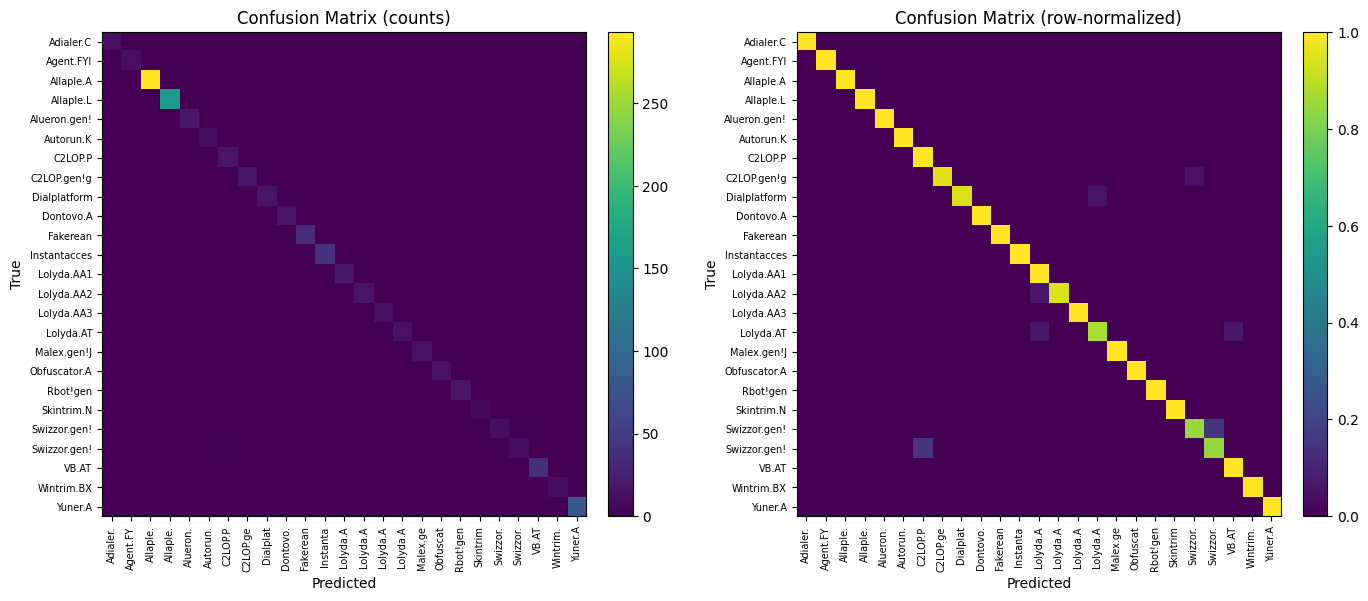


=== Worst classes by F1 ===


,class,support,precision,recall,f1
0,Swizzor.gen!I,13,0.8462,0.8462,0.8462
1,Swizzor.gen!E,13,0.9167,0.8462,0.8800
2,Lolyda.AT,16,0.9333,0.8750,0.9032
3,C2LOP.P,15,0.8824,1.0000,0.9375
4,Lolyda.AA1,21,0.9130,1.0000,0.9545
5,Dialplatform.B,18,1.0000,0.9444,0.9714
6,Lolyda.AA2,18,1.0000,0.9444,0.9714
7,C2LOP.gen!g,20,1.0000,0.9500,0.9744
8,VB.AT,41,0.9762,1.0000,0.9880
9,Allaple.L,159,0.9876,1.0000,0.9938



=== Best classes by F1 ===


,class,support,precision,recall,f1
15,Adialer.C,12,1.0,1.0,1.0
16,Lolyda.AA3,12,1.0,1.0,1.0
17,Dontovo.A,16,1.0,1.0,1.0
18,Fakerean,38,1.0,1.0,1.0
19,Malex.gen!J,14,1.0,1.0,1.0
20,Skintrim.N,8,1.0,1.0,1.0
21,Rbot!gen,16,1.0,1.0,1.0
22,Obfuscator.AD,14,1.0,1.0,1.0
23,Wintrim.BX,10,1.0,1.0,1.0
24,Yuner.A,80,1.0,1.0,1.0


In [26]:
# ====== EVALUATION: metrics + confusion matrices ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, precision_recall_fscore_support, roc_auc_score
)
import pandas as pd
model = teacher
# 1) Collect predictions and targets
y_true_onehot = []
y_prob = []
for xb, yb in val_ds:
    pb = model.predict(xb, verbose=0)
    y_prob.append(pb)
    y_true_onehot.append(yb.numpy())

y_prob = np.concatenate(y_prob, axis=0)                   # [N, C]
y_true_onehot = np.concatenate(y_true_onehot, axis=0)     # [N, C]
y_true = y_true_onehot.argmax(1)                          # [N]
y_pred = y_prob.argmax(1)                                 # [N]

# 2) Core metrics
acc        = accuracy_score(y_true, y_pred)
f1_macro   = f1_score(y_true, y_pred, average='macro')
f1_weight  = f1_score(y_true, y_pred, average='weighted')
f1_micro   = f1_score(y_true, y_pred, average='micro')

# Top-k utility
def topk_acc(probs, y_true_idx, k=5):
    # True if the true class is in the top-k predicted
    topk = np.argpartition(probs, -k, axis=1)[:, -k:]
    hits = (topk == y_true_idx[:, None]).any(axis=1)
    return hits.mean()

top5 = topk_acc(y_prob, y_true, k=5)

print(f"Accuracy        : {acc:.4f}")
print(f"F1 (macro)      : {f1_macro:.4f}")
print(f"F1 (weighted)   : {f1_weight:.4f}")
print(f"F1 (micro)      : {f1_micro:.4f}")
print(f"Top-5 Accuracy  : {top5:.4f}")

# Optional: macro AUC (OVR) needs probabilities + one-hot
try:
    auc_macro = roc_auc_score(y_true_onehot, y_prob, multi_class='ovr', average='macro')
    print(f"ROC AUC (macro, OVR): {auc_macro:.4f}")
except Exception as e:
    print("ROC AUC not computed:", e)

# 3) Classification report (per-class)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\n=== Classification report ===\n", report)

# 4) Confusion matrices
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_norm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cm, interpolation='nearest')
axes[0].set_title('Confusion Matrix (counts)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
axes[0].set_xticks(range(NUM_CLASSES)); axes[0].set_yticks(range(NUM_CLASSES))
axes[0].set_xticklabels([c[:8] for c in class_names], rotation=90, fontsize=7)
axes[0].set_yticklabels([c[:12] for c in class_names], fontsize=7)
fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

im = axes[1].imshow(cm_norm, vmin=0.0, vmax=1.0, interpolation='nearest')
axes[1].set_title('Confusion Matrix (row-normalized)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
axes[1].set_xticks(range(NUM_CLASSES)); axes[1].set_yticks(range(NUM_CLASSES))
axes[1].set_xticklabels([c[:8] for c in class_names], rotation=90, fontsize=7)
axes[1].set_yticklabels([c[:12] for c in class_names], fontsize=7)
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 5) Per-class table (precision/recall/F1/support)
prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=range(NUM_CLASSES), zero_division=0
)
per_class_df = pd.DataFrame({
    "class": class_names,
    "support": sup,
    "precision": np.round(prec, 4),
    "recall": np.round(rec, 4),
    "f1": np.round(f1, 4),
}).sort_values("f1", ascending=True).reset_index(drop=True)

print("\n=== Worst classes by F1 ===")
display(per_class_df.head(10))
print("\n=== Best classes by F1 ===")
display(per_class_df.tail(10))


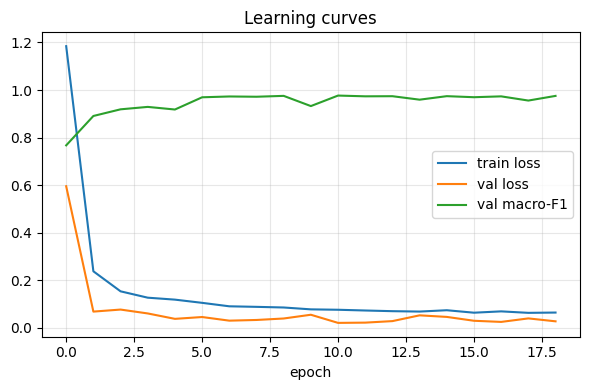

In [27]:
def plot_history(history):
    h = history.history
    fig = plt.figure(figsize=(6,4))
    if 'loss' in h: plt.plot(h['loss'], label='train loss')
    if 'val_loss' in h: plt.plot(h['val_loss'], label='val loss')
    if 'macro_f1' in h: plt.plot(h['macro_f1'], label='train macro-F1')
    if 'val_macro_f1' in h: plt.plot(h['val_macro_f1'], label='val macro-F1')
    plt.xlabel("epoch"); plt.legend(); plt.title("Learning curves")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

plot_history(history_t)  # teacher History


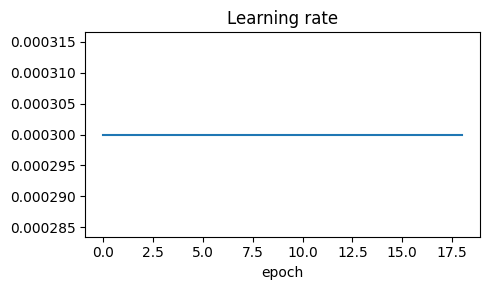

In [28]:
# if you used a Keras schedule object "lr_schedule" or logged LRs:
lrs = history_t.history.get('lr') or [float(teacher.optimizer.learning_rate)]*len(history_t.history['loss'])
plt.figure(figsize=(5,3)); plt.plot(lrs); plt.title("Learning rate"); plt.xlabel("epoch"); plt.tight_layout(); plt.show()


In [29]:
import tensorflow as tf, numpy as np

y_true, y_prob = [], []
for xb, yb in val_ds:
    logits = teacher(xb, training=False).numpy()
    y_prob.append(tf.nn.softmax(logits).numpy())
    y_true.append(yb.numpy())
y_true = np.concatenate(y_true)         # [N, C] one-hot
y_prob = np.concatenate(y_prob)         # [N, C]
y_pred = y_prob.argmax(1)
y_true_cls = y_true.argmax(1)


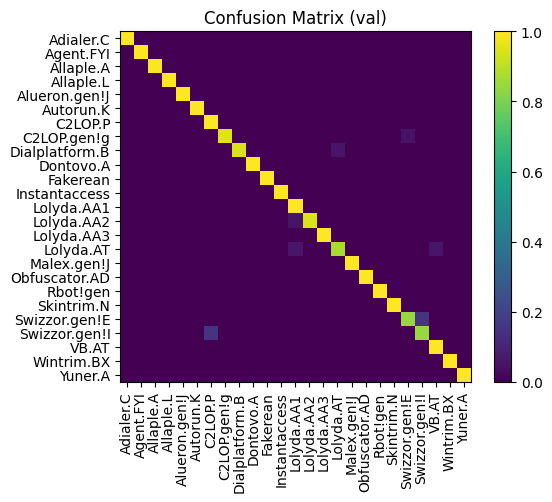

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_cls, y_pred, labels=range(len(class_names)))
cmn = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(6,5))
plt.imshow(cmn, interpolation='nearest')
plt.title("Confusion Matrix (val)"); plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.tight_layout(); plt.show()


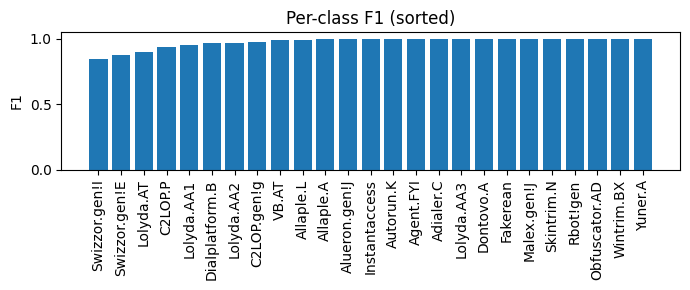

In [31]:
from sklearn.metrics import precision_recall_fscore_support
prec, rec, f1, sup = precision_recall_fscore_support(y_true_cls, y_pred, labels=range(len(class_names)), zero_division=0)
order = np.argsort(f1)
plt.figure(figsize=(7,3))
plt.bar(range(len(class_names)), f1[order])
plt.xticks(range(len(class_names)), [class_names[i] for i in order], rotation=90)
plt.ylabel("F1"); plt.title("Per-class F1 (sorted)"); plt.tight_layout(); plt.show()


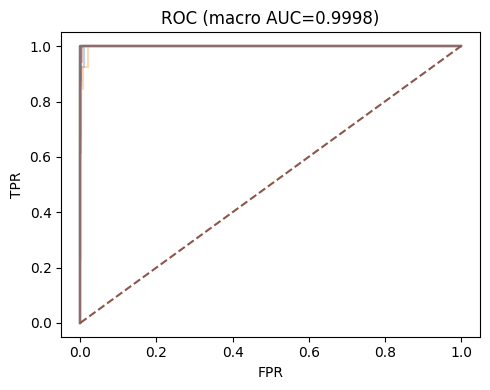

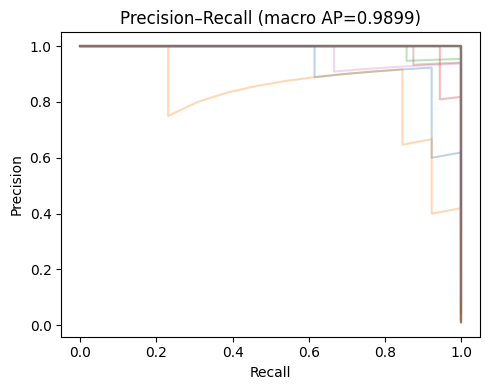

In [32]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC macro
fprs, tprs, aucs = [], [], []
for c in range(len(class_names)):
    f, t, _ = roc_curve(y_true[:,c], y_prob[:,c])
    fprs.append(f); tprs.append(t); aucs.append(auc(f,t))
plt.figure(figsize=(5,4))
for f,t in zip(fprs, tprs): plt.plot(f,t, alpha=0.3)
plt.plot([0,1],[0,1],'--')
plt.title(f"ROC (macro AUC={np.mean(aucs):.4f})"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.show()

# PR macro
aps = []
plt.figure(figsize=(5,4))
for c in range(len(class_names)):
    p, r, _ = precision_recall_curve(y_true[:,c], y_prob[:,c])
    plt.plot(r, p, alpha=0.3)
    aps.append(average_precision_score(y_true[:,c], y_prob[:,c]))
plt.title(f"Precision–Recall (macro AP={np.mean(aps):.4f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()


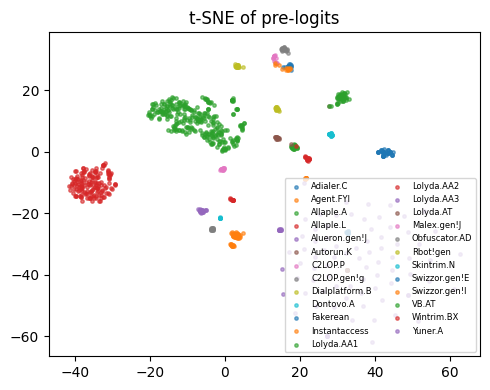

In [33]:
# pre-logits = the vector before Dense logits; if no named layer, use teacher.layers[-2] output
feat_extractor = keras.Model(teacher.input, teacher.get_layer("logits").input)
feats, labels = [], []
for xb, yb in val_ds:
    feats.append(feat_extractor(xb, training=False).numpy())
    labels.append(yb.numpy().argmax(1))
feats = np.concatenate(feats); labels = np.concatenate(labels)

# t-SNE (UMAP if you have umap-learn)
from sklearn.manifold import TSNE
Z = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(feats)

plt.figure(figsize=(5,4))
for c in range(len(class_names)):
    idx = labels==c
    plt.scatter(Z[idx,0], Z[idx,1], s=6, alpha=0.6, label=class_names[c])
plt.legend(ncol=2, fontsize=6); plt.title("t-SNE of pre-logits"); plt.tight_layout(); plt.show()


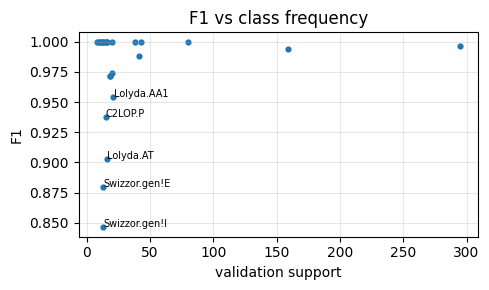

In [34]:
support = np.array([np.sum(y_true_cls==i) for i in range(len(class_names))])
plt.figure(figsize=(5,3))
plt.scatter(support, f1, s=12)
for i in np.argsort(f1)[:5]:
    plt.text(support[i]*1.01, f1[i], class_names[i], fontsize=7)
plt.xlabel("validation support"); plt.ylabel("F1"); plt.title("F1 vs class frequency")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


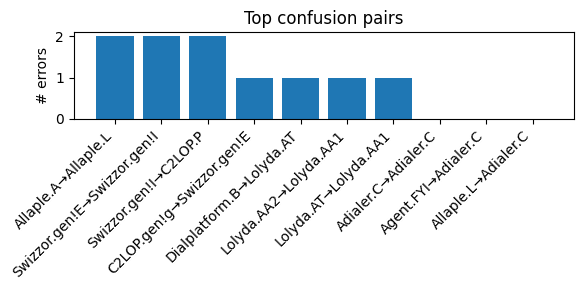

In [35]:
offdiag = cm.astype(float)
np.fill_diagonal(offdiag, 0)
pairs = []
for i in range(len(class_names)):
    j = offdiag[i].argmax()
    pairs.append((class_names[i], class_names[j], int(offdiag[i, j])))
pairs = sorted(pairs, key=lambda t: t[2], reverse=True)[:10]

plt.figure(figsize=(6,3))
plt.bar(range(len(pairs)), [p[2] for p in pairs])
plt.xticks(range(len(pairs)), [f"{a}→{b}" for a,b,_ in pairs], rotation=45, ha='right')
plt.ylabel("# errors"); plt.title("Top confusion pairs"); plt.tight_layout(); plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


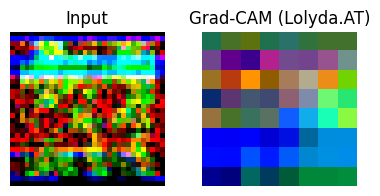

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

conv_name = [l.name for l in teacher.layers if isinstance(l, layers.Conv2D)][-2]  # e.g., the 1x1 fuse
conv_layer = teacher.get_layer(conv_name)

grad_model = keras.Model(
    [teacher.inputs],
    [conv_layer.output, teacher.output]
)

def grad_cam(img, class_idx=None):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img, training=False)
        if class_idx is None:
            class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)[0]                # H,W,C
    weights = tf.reduce_mean(grads, axis=(0,1))             # C
    cam = tf.reduce_sum(tf.maximum(conv_out[0],0) * weights, axis=-1).numpy()  # H,W
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-12)
    return cam, int(class_idx)

xb, yb = next(iter(val_ds.unbatch().batch(1)))
cam, cls = grad_cam(xb)
cam = np.array(cam)
plt.figure(figsize=(4,2))
plt.subplot(1,2,1); plt.imshow(xb[0]); plt.axis('off'); plt.title("Input")
plt.subplot(1,2,2); plt.imshow(xb[0]); plt.imshow(cam, cmap='jet', alpha=0.45); plt.axis('off'); plt.title(f"Grad-CAM ({class_names[cls]})")
plt.tight_layout(); plt.show()


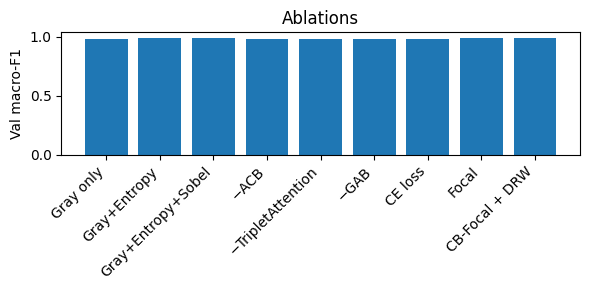

In [37]:
results = {
    "Gray only": 0.982,
    "Gray+Entropy": 0.987,
    "Gray+Entropy+Sobel": 0.989,
    "−ACB": 0.984,
    "−TripletAttention": 0.985,
    "−GAB": 0.986,
    "CE loss": 0.984,
    "Focal": 0.987,
    "CB-Focal + DRW": 0.989
}
plt.figure(figsize=(6,3))
names, scores = zip(*results.items())
plt.bar(range(len(names)), scores)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylabel("Val macro-F1"); plt.title("Ablations"); plt.tight_layout(); plt.show()


Per-channel min/max:
Gray    : -3.4216 .. 2.0380
Entropy : -4.5717 .. 1.5236
Sobel   : -1.4480 .. 3.2726


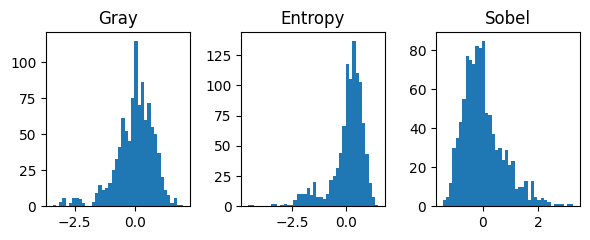

In [38]:
import numpy as np, matplotlib.pyplot as plt

# grab exactly one sample from the *pre-aug* dataset if you want deterministic view:
xb, yb = next(iter(train_ds_aug.unbatch().batch(1)))
img = xb[0].numpy()  # [32,32,3] expected in [0,1]

names = ["Gray","Entropy","Sobel"]
print("Per-channel min/max:")
for i,n in enumerate(names):
    vmin, vmax = float(img[...,i].min()), float(img[...,i].max())
    print(f"{n:8s}: {vmin:.4f} .. {vmax:.4f}")

# histograms to see if one channel is squashed
plt.figure(figsize=(6,2.5))
for i,n in enumerate(names):
    ax = plt.subplot(1,3,i+1)
    ax.hist(img[...,i].ravel(), bins=40); ax.set_title(n)
plt.tight_layout(); plt.show()


In [39]:
# # ================================
# # Student (Nano & Micro) + Distiller + Train Snippet
# # ================================
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# IMG_SIZE     = 32
# NUM_CHANNELS = 3  # Gray | Entropy | Sobel

# # ---------- helpers ----------
# def show_model_size(m):
#     p = m.count_params()
#     print(f"{m.name}: params={p:,}  ~{p*4/(1024**2):.2f} MB (float32)")

# # ---------- paper-inspired modules ----------
# class AsymmetricConvBlock(layers.Layer):
#     """ACB: 3x3 + (1x3) + (3x1) -> BN -> GELU."""
#     def __init__(self, out_ch, use_bias=False):
#         super().__init__()
#         self.conv33 = layers.Conv2D(out_ch, 3, padding="same", use_bias=use_bias)
#         self.conv13 = layers.Conv2D(out_ch, (1,3), padding="same", use_bias=use_bias)
#         self.conv31 = layers.Conv2D(out_ch, (3,1), padding="same", use_bias=use_bias)
#         self.bn = layers.BatchNormalization()
#         self.act = layers.Activation(tf.nn.gelu)
#     def call(self, x, training=False):
#         y = self.conv33(x) + self.conv13(x) + self.conv31(x)
#         y = self.bn(y, training=training)
#         return self.act(y)

# class TripletAttention(layers.Layer):
#     """WACV'21 Triplet Attention (compact)."""
#     def __init__(self, kernel_size=7):
#         super().__init__()
#         self.conv = layers.Conv2D(1, kernel_size, padding="same", use_bias=False)
#         self.bn   = layers.BatchNormalization()
#     def _branch(self, x, training=False):
#         xm = tf.reduce_max(x, axis=-1, keepdims=True)
#         xa = tf.reduce_mean(x, axis=-1, keepdims=True)
#         y  = tf.concat([xm, xa], axis=-1)
#         y  = self.conv(y); y = self.bn(y, training=training)
#         w  = tf.nn.sigmoid(y)
#         return x * w
#     def _perm(self, x, perm, inv, training=False):
#         y = tf.transpose(x, perm)
#         y = self._branch(y, training=training)
#         return tf.transpose(y, inv)
#     def call(self, x, training=False):
#         b1 = self._branch(x, training=training)
#         b2 = self._perm(x, (0,2,1,3), (0,2,1,3), training=training)
#         b3 = self._perm(x, (0,3,2,1), (0,3,2,1), training=training)
#         return (b1 + b2 + b3) / 3.0

# class GlobalAttentionBlock(layers.Layer):
#     """Light global attention: channel SE + spatial gate."""
#     def __init__(self, r=4):
#         super().__init__()
#         self.r = r
#         self.pool = layers.GlobalAveragePooling2D()
#         self.act  = layers.Activation(tf.nn.gelu)
#         self.spatial = layers.Conv2D(1, 1, padding="same")
#     def build(self, input_shape):
#         c = int(input_shape[-1])
#         self.fc1 = layers.Dense(max(c//self.r, 8), use_bias=False)
#         self.fc2 = layers.Dense(c, use_bias=False)
#     def call(self, x, training=False):
#         z = self.pool(x)
#         z = self.fc1(z); z = self.act(z)
#         z = self.fc2(z); z = tf.nn.sigmoid(z)
#         x = x * tf.reshape(z, [-1,1,1,tf.shape(x)[-1]])
#         s = tf.nn.sigmoid(self.spatial(x))
#         return x * s

# # ---------- tiny blocks ----------
# def ResBlock_AsymTA_bn(x, out_ch, stride=1, bottleneck_div=6):
#     """Res-like block with ACB in bottleneck; smaller inner width via bottleneck_div."""
#     inner = max(out_ch // bottleneck_div, 8)
#     skip = x
#     if stride != 1 or x.shape[-1] != out_ch:
#         skip = layers.Conv2D(out_ch, 1, strides=stride, use_bias=False, padding="same")(skip)
#         skip = layers.BatchNormalization()(skip)
#     y = layers.Conv2D(inner, 1, strides=stride, use_bias=False, padding="same")(x)
#     y = layers.BatchNormalization()(y); y = layers.Activation(tf.nn.gelu)(y)
#     y = AsymmetricConvBlock(inner)(y)
#     y = layers.Conv2D(out_ch, 1, use_bias=False, padding="same")(y)
#     y = layers.BatchNormalization()(y)
#     y = TripletAttention()(y)
#     y = layers.Add()([skip, y])
#     return layers.Activation(tf.nn.gelu)(y)

# def VGGBlock_AsymTA(x, out_ch, blocks=1, pool=True):
#     for _ in range(blocks):
#         x = AsymmetricConvBlock(out_ch)(x)
#         x = TripletAttention()(x)
#     if pool:
#         x = layers.MaxPooling2D(2)(x)
#     return x

# # ---------- STUDENT: Nano (<3 MB) ----------
# def build_student_mckdff_nano(num_classes, in_ch=NUM_CHANNELS,
#                               res_widths=(48, 96, 128),
#                               vgg_widths=(48, 96, 96),
#                               bottleneck_div=6,
#                               fuse_ch=96):
#     """
#     ~0.5–1.5 MB typically (float32), depending on your Keras/BN params.
#     32x32 input -> two light branches -> concat -> 1x1 fuse -> GAB -> GAP -> logits.
#     """
#     inp = layers.Input((None, None, in_ch))
#     x   = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)

#     # Res branch (3 blocks total)
#     r = layers.Conv2D(24, 3, padding="same", use_bias=False)(x); r = layers.BatchNormalization()(r); r = layers.Activation(tf.nn.gelu)(r)
#     r = ResBlock_AsymTA_bn(r, res_widths[0], stride=1, bottleneck_div=bottleneck_div)  # 32x32
#     r = ResBlock_AsymTA_bn(r, res_widths[1], stride=2, bottleneck_div=bottleneck_div)  # 32->16
#     r = ResBlock_AsymTA_bn(r, res_widths[2], stride=2, bottleneck_div=bottleneck_div)  # 16->8

#     # VGG branch (narrow)
#     v = layers.Conv2D(24, 3, padding="same", use_bias=False)(x); v = layers.BatchNormalization()(v); v = layers.Activation(tf.nn.gelu)(v)
#     v = VGGBlock_AsymTA(v, vgg_widths[0], blocks=1, pool=True)   # 32->16
#     v = VGGBlock_AsymTA(v, vgg_widths[1], blocks=1, pool=True)   # 16->8
#     v = VGGBlock_AsymTA(v, vgg_widths[2], blocks=1, pool=False)  # 8x8

#     # Fuse + head
#     f = layers.Concatenate()([r, v])                 # 8x8 concat
#     f = layers.Conv2D(fuse_ch, 1, use_bias=False, padding="same")(f)
#     f = layers.BatchNormalization()(f); f = layers.Activation(tf.nn.gelu)(f)
#     f = GlobalAttentionBlock(r=4)(f)
#     f = layers.GlobalAveragePooling2D()(f)
#     logits = layers.Dense(num_classes, activation=None, name="logits")(f)
#     return keras.Model(inp, logits, name="Student_MCKDFF_32_Nano")

# # ---------- STUDENT: Micro (ultra-small) ----------
# def build_student_mckdff_micro(num_classes, in_ch=NUM_CHANNELS,
#                                res_widths=(32, 64, 96),
#                                vgg_widths=(32, 64, 64),
#                                bottleneck_div=8,
#                                fuse_ch=64):
#     """
#     ~0.3–0.9 MB typically (float32). Use if you want an even smaller footprint.
#     """
#     inp = layers.Input((None, None, in_ch))
#     x   = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)

#     r = layers.Conv2D(16, 3, padding="same", use_bias=False)(x); r = layers.BatchNormalization()(r); r = layers.Activation(tf.nn.gelu)(r)
#     r = ResBlock_AsymTA_bn(r, res_widths[0], stride=1, bottleneck_div=bottleneck_div)  # 32x32
#     r = ResBlock_AsymTA_bn(r, res_widths[1], stride=2, bottleneck_div=bottleneck_div)  # 32->16
#     r = ResBlock_AsymTA_bn(r, res_widths[2], stride=2, bottleneck_div=bottleneck_div)  # 16->8

#     v = layers.Conv2D(16, 3, padding="same", use_bias=False)(x); v = layers.BatchNormalization()(v); v = layers.Activation(tf.nn.gelu)(v)
#     v = VGGBlock_AsymTA(v, vgg_widths[0], blocks=1, pool=True)   # 32->16
#     v = VGGBlock_AsymTA(v, vgg_widths[1], blocks=1, pool=True)   # 16->8
#     v = VGGBlock_AsymTA(v, vgg_widths[2], blocks=1, pool=False)  # 8x8

#     f = layers.Concatenate()([r, v])
#     f = layers.Conv2D(fuse_ch, 1, use_bias=False, padding="same")(f)
#     f = layers.BatchNormalization()(f); f = layers.Activation(tf.nn.gelu)(f)
#     f = GlobalAttentionBlock(r=4)(f)
#     f = layers.GlobalAveragePooling2D()(f)
#     logits = layers.Dense(num_classes, activation=None, name="logits")(f)
#     return keras.Model(inp, logits, name="Student_MCKDFF_32_Micro")

# # ---------- Distiller (KD + CB-Focal) ----------
# class Distiller(keras.Model):
#     """
#     KD: KL( softmax(t/T) || softmax(s/T) ) * T^2
#     Hard: cb_focal(y_true, softmax(s_logits))
#     Total: alpha*KD + (1-alpha)*Hard
#     """
#     def __init__(self, student, teacher, temperature=3.0, alpha=0.6,
#                  feat_weight=0.0, teacher_feat_model=None, student_feat_model=None):
#         super().__init__()
#         self.student = student
#         self.teacher = teacher
#         self.T = float(temperature)
#         self.alpha = float(alpha)
#         self.kld = keras.losses.KLDivergence(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
#         self.feat_weight = float(feat_weight)
#         self.T_feat = teacher_feat_model
#         self.S_feat = student_feat_model
#         self.loss_tracker = keras.metrics.Mean(name="loss")
#         self.kd_tracker   = keras.metrics.Mean(name="kd_loss")
#         self.hard_tracker = keras.metrics.Mean(name="hard_loss")
#         self.acc          = keras.metrics.CategoricalAccuracy(name="acc")
#     def call(self, x, training=False):
#         return self.student(x, training=training)  # logits
#     @property
#     def metrics(self): return [self.loss_tracker, self.kd_tracker, self.hard_tracker, self.acc]
#     def train_step(self, data):
#         x, y = data
#         t_logits = self.teacher(x, training=False)
#         t_soft   = tf.nn.softmax(t_logits / self.T)
#         with tf.GradientTape() as tape:
#             s_logits = self.student(x, training=True)
#             s_soft   = tf.nn.softmax(s_logits / self.T)
#             kd_loss   = (self.T * self.T) * self.kld(t_soft, s_soft)
#             hard_loss = cb_focal(y, tf.nn.softmax(s_logits))
#             loss = self.alpha * kd_loss + (1.0 - self.alpha) * hard_loss
#             if self.feat_weight > 0.0 and (self.T_feat is not None) and (self.S_feat is not None):
#                 t_feat = self.T_feat(x, training=False)
#                 s_feat = self.S_feat(x, training=True)
#                 t_n = tf.math.l2_normalize(t_feat, axis=-1)
#                 s_n = tf.math.l2_normalize(s_feat, axis=-1)
#                 feat_loss = tf.reduce_mean(tf.square(s_n - t_n))
#                 loss += self.feat_weight * feat_loss
#         grads = tape.gradient(loss, self.student.trainable_variables)
#         self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
#         self.kd_tracker.update_state(kd_loss)
#         self.hard_tracker.update_state(hard_loss)
#         self.loss_tracker.update_state(loss)
#         self.acc.update_state(y, tf.nn.softmax(s_logits))
#         return {m.name: m.result() for m in self.metrics}
#     def test_step(self, data):
#         x, y = data
#         s_logits = self.student(x, training=False)
#         hard_loss = cb_focal(y, tf.nn.softmax(s_logits))
#         self.hard_tracker.update_state(hard_loss)
#         self.loss_tracker.update_state(hard_loss)
#         self.acc.update_state(y, tf.nn.softmax(s_logits))
#         return {m.name: m.result() for m in self.metrics}

# # ======================
# # choose your student (both <3 MB by design)
# # ======================
# student_nano  = build_student_mckdff_nano(NUM_CLASSES, in_ch=NUM_CHANNELS)
# student_micro = build_student_mckdff_micro(NUM_CLASSES, in_ch=NUM_CHANNELS)

# student = student_micro  # <-- pick one
# student.summary(); show_model_size(student)

# # teacher = 
# # KD trainer
# teacher.trainable = False
# from tensorflow.keras.optimizers import AdamW
# distiller = Distiller(student=student, teacher=teacher, temperature=3.0, alpha=0.6)
# distiller.compile(optimizer=AdamW(learning_rate=3e-4, weight_decay=1e-4))

# # checkpoints (optional)
# ckpt_student = keras.callbacks.ModelCheckpoint(
#     "best_student_kd32.weights.h5",
#     monitor="val_macro_f1", mode="max",
#     save_best_only=True, save_weights_only=True
# )

# # Train
# # history_kd = distiller.fit(
# #     train_ds_aug,
# #     validation_data=val_ds,
# #     epochs=40,
# #     callbacks=[DRWCallback(cb_focal, start_epoch=10), macro_f1_cb, ckpt_student, early],
# #     verbose=1
# # )

# # Save distilled student (omit optimizer to avoid schedule serialization issues)
# # distiller.student.save("student_kd32.keras", include_optimizer=False)
# # distiller.student.save_weights("student_kd32.weights.h5")


In [40]:
# history_kd = distiller.fit(
#     train_ds_aug,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=[DRWCallback(cb_focal, start_epoch=10), macro_f1_cb, ckpt_student, early],
#     verbose=1
# )

In [41]:
# # ====== EVALUATION: metrics + confusion matrices ======
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     accuracy_score, f1_score, classification_report,
#     confusion_matrix, precision_recall_fscore_support, roc_auc_score
# )
# import pandas as pd
# model = student
# # 1) Collect predictions and targets
# y_true_onehot = []
# y_prob = []
# for xb, yb in val_ds:
#     pb = model.predict(xb, verbose=0)
#     y_prob.append(pb)
#     y_true_onehot.append(yb.numpy())

# y_prob = np.concatenate(y_prob, axis=0)                   # [N, C]
# y_true_onehot = np.concatenate(y_true_onehot, axis=0)     # [N, C]
# y_true = y_true_onehot.argmax(1)                          # [N]
# y_pred = y_prob.argmax(1)                                 # [N]

# # 2) Core metrics
# acc        = accuracy_score(y_true, y_pred)
# f1_macro   = f1_score(y_true, y_pred, average='macro')
# f1_weight  = f1_score(y_true, y_pred, average='weighted')
# f1_micro   = f1_score(y_true, y_pred, average='micro')

# # Top-k utility
# def topk_acc(probs, y_true_idx, k=5):
#     # True if the true class is in the top-k predicted
#     topk = np.argpartition(probs, -k, axis=1)[:, -k:]
#     hits = (topk == y_true_idx[:, None]).any(axis=1)
#     return hits.mean()

# top5 = topk_acc(y_prob, y_true, k=5)

# print(f"Accuracy        : {acc:.4f}")
# print(f"F1 (macro)      : {f1_macro:.4f}")
# print(f"F1 (weighted)   : {f1_weight:.4f}")
# print(f"F1 (micro)      : {f1_micro:.4f}")
# print(f"Top-5 Accuracy  : {top5:.4f}")

# # Optional: macro AUC (OVR) needs probabilities + one-hot
# try:
#     auc_macro = roc_auc_score(y_true_onehot, y_prob, multi_class='ovr', average='macro')
#     print(f"ROC AUC (macro, OVR): {auc_macro:.4f}")
# except Exception as e:
#     print("ROC AUC not computed:", e)

# # 3) Classification report (per-class)
# report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
# print("\n=== Classification report ===\n", report)

# # 4) Confusion matrices
# cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
# cm_norm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# axes[0].imshow(cm, interpolation='nearest')
# axes[0].set_title('Confusion Matrix (counts)')
# axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
# axes[0].set_xticks(range(NUM_CLASSES)); axes[0].set_yticks(range(NUM_CLASSES))
# axes[0].set_xticklabels([c[:8] for c in class_names], rotation=90, fontsize=7)
# axes[0].set_yticklabels([c[:12] for c in class_names], fontsize=7)
# fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

# im = axes[1].imshow(cm_norm, vmin=0.0, vmax=1.0, interpolation='nearest')
# axes[1].set_title('Confusion Matrix (row-normalized)')
# axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
# axes[1].set_xticks(range(NUM_CLASSES)); axes[1].set_yticks(range(NUM_CLASSES))
# axes[1].set_xticklabels([c[:8] for c in class_names], rotation=90, fontsize=7)
# axes[1].set_yticklabels([c[:12] for c in class_names], fontsize=7)
# fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
# plt.tight_layout()
# plt.show()

# # 5) Per-class table (precision/recall/F1/support)
# prec, rec, f1, sup = precision_recall_fscore_support(
#     y_true, y_pred, labels=range(NUM_CLASSES), zero_division=0
# )
# per_class_df = pd.DataFrame({
#     "class": class_names,
#     "support": sup,
#     "precision": np.round(prec, 4),
#     "recall": np.round(rec, 4),
#     "f1": np.round(f1, 4),
# }).sort_values("f1", ascending=True).reset_index(drop=True)

# print("\n=== Worst classes by F1 ===")
# display(per_class_df.head(10))
# print("\n=== Best classes by F1 ===")
# display(per_class_df.tail(10))
